## PRÁCTICA BLOCKCHAIN
### Alejandro Manuel López Gómez

In [4]:
import matplotlib.pyplot as plt
import hashlib
import time
import json
from flask import Flask, request
import json
import requests
import time

class Block():
    def __init__(self,index,transactions,timestamp,previous_hash):
        self.index = index
        self.transactions = transactions
        self.timestamp = timestamp
        self.previous_hash = previous_hash
        
    def compute_hash(self):
        block_string = json.dumps(self.__dict__, sort_keys = True)
        return hashlib.sha256(block_string.encode('utf-8')).hexdigest()

class Blockchain():
    def __init__(self,difficulty):
        self.chain = []
        self.difficulty = difficulty
        self.unconfirmed_transactions = []
        self.create_genesis_block()
        
    def create_genesis_block(self):
        genesis_block = Block(0,[],time.time(),"0")
        genesis_block.current_hash = genesis_block.compute_hash()
        self.chain.append(genesis_block)
    
    def last_block(self):
        return self.chain[-1]
    
    def genesis_block(self):
        return self.chain[0]
    
    def proof_of_work(self,block):
        block.nonce = 0
        while True:
            block_hash = block.compute_hash()
            if (block_hash[:self.difficulty] == "".join(str(i) for i in [0]*self.difficulty)):
                break
            block.nonce += 1
        return block_hash
    
    def is_valid_proof(self,block,block_hash):
        if block_hash[:self.difficulty] == "".join(str(i) for i in [0]*self.difficulty) and block_hash == block.compute_hash():
            return True
        return False
    
    def append_block(self,block,block_hash):
        if block.previous_hash == self.last_block().current_hash and self.is_valid_proof(block,block_hash):
            block.current_hash = block_hash
            self.chain.append(block)
            return True
        return False

    def add_new_transaction(self,transaction):
        self.unconfirmed_transactions.append(transaction)
    
    def mine(self):
        if self.unconfirmed_transactions:
            new_block = Block(self.last_block().index+1,self.unconfirmed_transactions,time.time(),self.last_block().current_hash)
            proof = self.proof_of_work(new_block)
            self.append_block(new_block,proof)
            self.unconfirmed_transactions = []
            return self.last_block().index
        return False
    
    def check_chain(self,chain):
        for b in range(2,len(chain)):
            current_hash = chain[b].current_hash
            delattr(chain[b],'current_hash')
            if not (self.is_valid_proof(chain[b],current_hash) and chain[b].previous_hash == chain[b-1].current_hash):
                return False
            chain[b].current_hash = current_hash
        return True

In [2]:
block = Block(1,2,3,4)
block.compute_hash()

'268b3626a44ab7a87f2f0c7ee6e95c30b4ab1755fa96a2508125259340a9e339'

In [3]:
blockchain = Blockchain(2)
newblock = Block(blockchain.last_block().index+1,[],time.time(),blockchain.last_block().current_hash)
new_hash = blockchain.proof_of_work(newblock)
out = blockchain.append_block(newblock,new_hash)
print("Bloque añadido: ",out)
print(blockchain.genesis_block().__dict__)
print(blockchain.last_block().__dict__)

blockchain.add_new_transaction("data1")
blockchain.add_new_transaction("data2")
blockchain.add_new_transaction("data3")
blockchain.unconfirmed_transactions

new_index = blockchain.mine()
print("Indice del bloque minado: ",new_index)
print(blockchain.last_block().__dict__)

chain_to_check = blockchain.chain
print("Check de la cadena: ",blockchain.check_chain(chain_to_check))

Bloque añadido:  True
{'index': 0, 'transactions': [], 'timestamp': 1682871206.2195375, 'previous_hash': '0', 'current_hash': 'b4cdad07211dbd003635dd706689ab8070fec2e9f5cb97adf7b28039b0234fec'}
{'index': 1, 'transactions': [], 'timestamp': 1682871206.2205322, 'previous_hash': 'b4cdad07211dbd003635dd706689ab8070fec2e9f5cb97adf7b28039b0234fec', 'nonce': 296, 'current_hash': '00a41b9cc4425eb2d626550a43118d03676644c0b67f066f6400c2b8782cbc0b'}
Indice del bloque minado:  2
{'index': 2, 'transactions': ['data1', 'data2', 'data3'], 'timestamp': 1682871206.2235365, 'previous_hash': '00a41b9cc4425eb2d626550a43118d03676644c0b67f066f6400c2b8782cbc0b', 'nonce': 393, 'current_hash': '00a055aa1c9a247a0376dca1fb6af5bdd82e1d1f6d332669df01ddba34b31239'}
Check de la cadena:  True


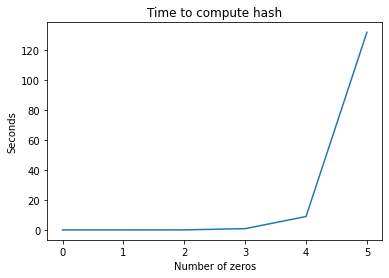

In [3]:
max_difficulty = 5
time_vector = []
zeros_vector = list(range(0,max_difficulty+1))
for i in range(0,max_difficulty+1):
    blockchain = Blockchain(i+1)
    newblock = Block(blockchain.last_block().index+1,[],time.time(),blockchain.last_block().current_hash)
    start = time.time()
    blockchain.proof_of_work(newblock)
    end = time.time()
    time_vector.append(end - start)

plt.plot(zeros_vector,time_vector)
plt.title('Time to compute hash')
plt.ylabel('Seconds')
plt.xlabel('Number of zeros')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import hashlib
import time
import json
from flask import Flask, request
import json
import requests
import time

app = Flask(__name__)
blockchain = Blockchain(2)
peers = set()
srv_port = "8000"

@app.route('/new_transaction',methods = {'POST'})
def new_transaction():
    data = request.get_json()
    required_fields = ["author","content"]

    if not all(f in data for f in required_fields):
        return ("Invalid transaction data", 404)
    
    data['timestamp'] = time.time()
    blockchain.add_new_transaction(data)
    return ("Success", 201)

@app.route('/chain',methods = {'GET'})
def get_chain():
    data = {"length": len(blockchain.chain),
            "chain" : [b.__dict__ for b in blockchain.chain],
            "peers" : list(peers)}
    return (json.dumps(data), 200)

@app.route('/mine',methods = {'GET'})
def mine():
    consensus()
    backup_unconfirmed_transactions = blockchain.unconfirmed_transactions 
    if blockchain.unconfirmed_transactions:
        new_index = blockchain.mine()
    
        if not consensus():
            announce_new_block(blockchain.last_block(),request)
            if peers:
                data = "Block has been mined and announced. New_block_index : " +str(new_index)
                return (data, 201)
            return ("Block was mined for current node, but not announced (no registered peers)", 201)
    
    blockchain.unconfirmed_transactions = backup_unconfirmed_transactions
    return ("Block was discarded or no pending transactions to mine", 400)

@app.route('/pending_transactions', methods = {'GET'})
def get_pending_transactions():
    if blockchain.unconfirmed_transactions:
        data = {"unconfirmed_transactions" : blockchain.unconfirmed_transactions}
        return (json.dumps(data), 200)
    return ("No unconfirmed transactions", 404)

@app.route('/register_new_node', methods = {'POST'})
def register_new_node():
    new_node_address = request.get_json()['new_node_address']
    if not new_node_address:
        return ("Invalid new node data", 400)
    
    if new_node_address not in peers:
        if new_node_address[:7] != "http://":
            peers.add("http://"+new_node_address)
        else:
            peers.add(new_node_address)
            
    return get_chain()

@app.route('/register_with_existing_node', methods = {'POST'})
def register_with_existing_node():
    node_address = request.get_json()['node_address']
    if not node_address:
        return ("Invalid node data", 400)
    data = {"new_node_address" : request.host_url[:-1]}
    headers = {'Content-Type' : "application/json"}
    
    response = requests.post("http://"+node_address+"/register_new_node",json=data,headers=headers)
    
    if response.status_code == 200:
        chain_dump = response.json()['chain']
        peer_dump = response.json()['peers']
        new_blockchain = Blockchain(2)
        new_blockchain.chain = []
        genesis_block = Block(chain_dump[0]['index'],chain_dump[0]['transactions'],chain_dump[0]['timestamp'],chain_dump[0]['previous_hash'])
        genesis_block.current_hash = genesis_block.compute_hash()
        new_blockchain.chain.append(genesis_block)
        
        for b in range(1,len(chain_dump)):
            block = Block(chain_dump[b]['index'],chain_dump[b]['transactions'],chain_dump[b]['timestamp'],chain_dump[b]['previous_hash'])
            block_hash = new_blockchain.proof_of_work(block)
            if not new_blockchain.append_block(block,block_hash):
                print("Invalid block")
        
        blockchain.chain = new_blockchain.chain
        peers.add("http://"+node_address)
        
        for p in peer_dump:
            if p!= request.host_url[:-1]:
                peers.add(p)
        
        return ("Registration successful",200)
    else:
        return response.content, response.status_code

@app.route('/add_block', methods = {'POST'})
def add_block():
    data = request.get_json()
    required_fields = ["index","transactions","timestamp","previous_hash","current_hash"]
    
    if not all(f in data for f in required_fields):
        return ("Invalid transaction data", 404)
    
    block = Block(data['index'],data['transactions'],data['timestamp'],data['previous_hash'])
    block_hash = data['current_hash']
    blockchain.proof_of_work(block)

    if not blockchain.append_block(block,block_hash):
        return ("Block has been discarded",400)
    return ("Success",200)

def announce_new_block(block, request):
    for peer in peers:
        if peer != request.host_url:
            data = json.dumps(block.__dict__,sort_keys = True)
            headers = {"Content-Type" : "application/json"}
            response = requests.post(peer+"/add_block",data=data,headers=headers)
            
def consensus():
    global blockchain
    longest_chain = None
    current_len = len(blockchain.chain)
    
    for node in peers:
        current_chain = (requests.get(node+"/chain")).json()["chain"]
        if len(current_chain) > current_len:
            current_len = len(current_chain)
            longest_chain = chain
            
    if longest_chain:
        blockchain.chain = longest_chain
        return True
    return False

if __name__ == "__main__":
    app.run(port=srv_port)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8000/ (Press CTRL+C to quit)
127.0.0.1 - - [30/Apr/2023 18:42:53] "POST /new_transaction HTTP/1.1" 201 -
127.0.0.1 - - [30/Apr/2023 18:42:54] "GET /pending_transactions HTTP/1.1" 200 -
127.0.0.1 - - [30/Apr/2023 18:42:55] "GET /mine HTTP/1.1" 201 -
127.0.0.1 - - [30/Apr/2023 18:42:55] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [30/Apr/2023 18:43:01] "GET /chain HTTP/1.1" 200 -
127.0.0.1 - - [30/Apr/2023 18:43:06] "POST /new_transaction HTTP/1.1" 201 -
127.0.0.1 - - [30/Apr/2023 18:43:06] "GET /pending_transactions HTTP/1.1" 200 -
127.0.0.1 - - [30/Apr/2023 18:43:08] "GET /mine HTTP/1.1" 201 -
127.0.0.1 - - [30/Apr/2023 18:43:13] "GET /chain HTTP/1.1" 200 -
